In [3]:
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from Unet import convbatchrelu, convdown, downsample, convup, upsample, Unet
from utils import set_seed, seed_worker, set_device

Random seed 2021 has been set.


In [4]:
# @title Download and normalize data
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

# we are going to normalize the images so their pixel values mostly fall between 0 and 1
# this is helpful if you have images on a variety of scales
# we will also return the images as float32 <- the data type that is fast for GPU computation
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)


imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

Plot a sample training image and its masks.

there are 90 cells in this image


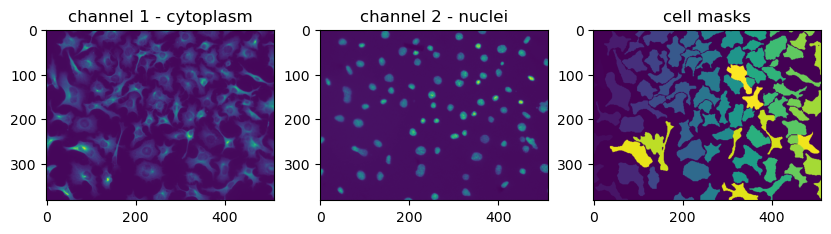

In [6]:
irand = np.random.randint(len(imgs_train))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(imgs_train[irand][0])
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 3, 2)
plt.imshow(imgs_train[irand][1])
plt.title('channel 2 - nuclei')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('cell masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

What labels should we use? The standard approach is to create a "not-cell" and a "cell" probability map for the network to learn. This map is then thresholded to identify cells. The threshold is determined using a validation dataset.

In [7]:
labels_train = np.zeros((len(masks_train), 2,
                         masks_train.shape[-2],
                         masks_train.shape[-1]),
                        np.longlong) # is it necessary to use longlong?
labels_train[:, 0] = masks_train == 0
labels_train[:, 1] = masks_train > 0

labels_test = np.zeros((len(masks_test), 2,
                        masks_test.shape[-2],
                        masks_test.shape[-1]),
                       np.longlong)
labels_test[:, 0] = masks_test == 0
labels_test[:, 1] = masks_test > 0

## Create transform function for augmentations

adapted from [cellpose/transforms.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/transforms.py).

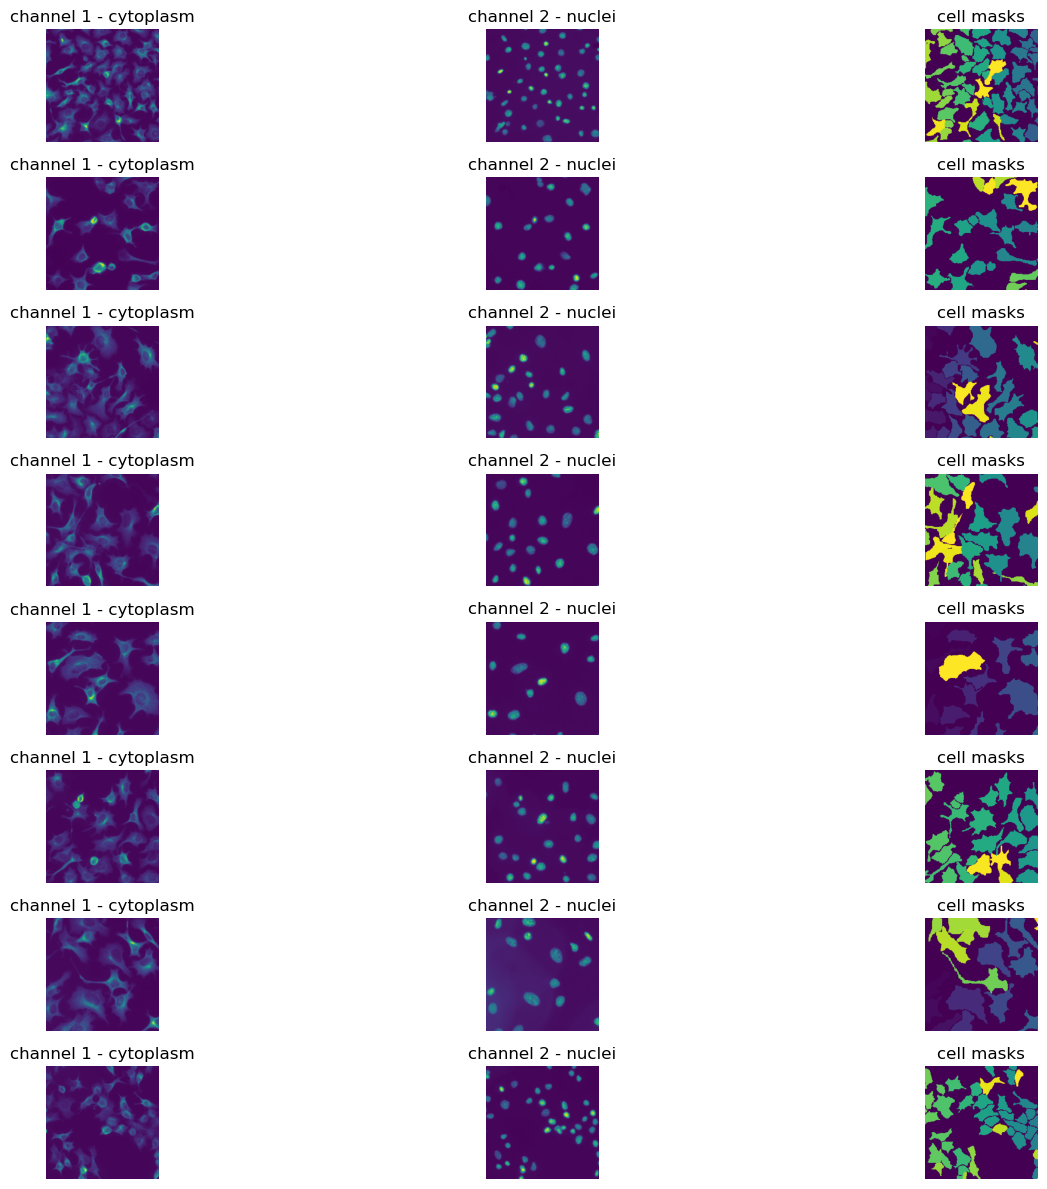

In [ ]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  #xy = X[0].shape[1:]
  #print(xy)

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    """Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)"""

    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    
    # generate random scale parameter only
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    
    # create simple scaling transform
    M = np.array([[scale[n], 0, 0],
                  [0, scale[n], 0]], dtype=np.float32)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I
      #print(imgi.shape, img[:,:-1].shape)
      #imgi[n,k] = img[k, :-1]

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)
        #lbl[n,k] = labels[k, :-1]

  return imgi, lbl, scale


img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       masks_train[:8])

plt.figure(figsize=(16, 12))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 0])
  plt.title('cell masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

## Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


### Define the network

In [ ]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

Unet(
  (downsample): downsample(
    (down): Sequential(
      (conv_down_0): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
      )
      (conv_down_1): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequent

### Train the network

Here we've implemented code to train the network.

Note we probably should be evaluating test performance throughout training -- implement that yourself.

In [ ]:
from datetime import datetime

args = {
   'batch_size': 8, # number of images per batch -- amount of required memory for training will increase linearly in batchsize
   'n_epochs': 2, # number of times to cycle through all the data during training
   'learning_rate': 0.1, # initial learning rate
   'weight_decay': 1e-5, # L2 regularization of weights
   'momentum': 0.9, # how much to use previous gradient direction
   'val_frac': 0.05, # what fraction of data to use for validation
   'n_epochs_per_save' : 25 # how often to save the network
}

# today's date for saving the network - clean regularly to free up space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

# split training data into train and validation datasets
n_val = int(len(imgs_train) * args['val_frac']) # number of samples in validation dataset
n_train = len(imgs_train) - n_val # number of samples in train dataset
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train)) # is this permutation strictly necessary? it randomizes the order of the data - does that make a difference?
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = labels_train[iperm[:n_train]], labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# stochastic gradient descent
optimizer = torch.optim.SGD(net.parameters(),
                            lr=args['learning_rate'],
                            weight_decay=args['weight_decay'],
                            momentum=args['momentum'])

# set learning rate schedule (maybe do without learning rate schedule first, then with later)
LR = np.linspace(0, args['learning_rate'], 10)
if args['n_epochs'] > 250:
    LR = np.append(LR, args['learning_rate']*np.ones(args['n_epochs']-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, args['learning_rate'] * np.ones(max(0, args['n_epochs'] - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(args['n_epochs'])
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through training dataset n_epochs number of times
for epoch in range(args['n_epochs']):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{args['n_epochs']}", unit='img') as pbar:
    # loop through each batch in the training data
    for ibatch in np.arange(0, n_train, args['batch_size']):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+args['batch_size']))
      train_data = train_data.astype(np.float32)
      train_labels = train_labels.astype(np.float32)
      imgs, lbls, _ = random_rotate_and_resize(train_data[inds],
                                               train_labels[inds])

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)
      lbls = lbls.long()

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 1])
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    epoch_losses[epoch] = epoch_loss
    pbar.set_postfix(**{'loss (epoch)': epoch_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % args['n_epochs_per_save'] == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/2: 100%|██████████| 77/77 [00:48<00:00,  1.58img/s, loss (epoch)=6.98] 



Saving network state at epoch 1


Epoch 2/2: 100%|██████████| 77/77 [00:45<00:00,  1.68img/s, loss (epoch)=3.38] 


Saving network state at epoch 2


In [ ]:
def set_learning_rate(initial_learning_rate = 1e-4, n_epochs = 50):
    """
    Set learning rate schedule (maybe do training without learning rate schedule first, then with later)
    """
    LR = np.linspace(0, args['learning_rate'], 10)
    if args['n_epochs'] > 250:
        LR = np.append(LR, args['learning_rate']*np.ones(args['n_epochs']-100))
        for i in range(10):
            LR = np.append(LR, LR[-1]/2 * np.ones(10))
    else:
        LR = np.append(LR, args['learning_rate'] * np.ones(max(0, args['n_epochs'] - 10)))
    return LR

'cpu'

In [ ]:
def train(args, model, device, optimizer, criterion, save_network=True, apply_lr_schedule=False):

    if save_network:
        # today's date for saving the network - clean regularly to free up space
        now = datetime.now()
        timestamp = now.strftime('%Y%m%dT%H%M%S')

    if apply_lr_schedule:
        LR = set_learning_rate(initial_lr = args['init_learning_rate'], n_epochs=args['n_epochs'])
    else:
        LR = [args['init_learning_rate']]*args['n_epochs']

    """Replace the code below with torch or torchvisions data split functions and put it outside the train function"""
    # split training data into train and validation datasets
    n_val = int(len(imgs_train) * args['val_frac']) # number of samples in validation dataset
    n_train = len(imgs_train) - n_val # number of samples in train dataset
    np.random.seed(0)
    iperm = np.random.permutation(len(imgs_train)) # is this permutation strictly necessary? it randomizes the order of the data - does that make a difference?
    train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
    train_labels, val_labels = labels_train[iperm[:n_train]], labels_train[iperm[n_train:]]
    train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]

    # store loss per epoch
    epoch_losses = np.zeros(args['n_epochs'])
    epoch_losses[:] = np.nan

    # loop through training dataset n_epochs number of times
    for epoch in range(args['n_epochs']):
        model.train() # put in train mode (affects batchnorm)
        epoch_loss = 0
        iters = 0
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR[epoch]

        with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{args['n_epochs']}", unit='img') as pbar:
            # loop through each batch in the training data
            for ibatch in np.arange(0, n_train, args['batch_size']):
                # augment the data
                inds = np.arange(ibatch, min(n_train, ibatch+args['batch_size']))
                train_data = train_data.astype(np.float32)
                train_labels = train_labels.astype(np.float32)

                # is it necessary to augment anew for every batch??
                images, labels, _ = random_rotate_and_resize(train_data[inds],
                                                        train_labels[inds])

                # transfer to torch + GPU
                images = torch.from_numpy(images).to(device=device)
                labels = torch.from_numpy(labels).to(device=device)
                labels = labels.long()

                # zero out previous gradients
                optimizer.zero_grad()

                # predict labels with model
                labels_pred = model(images)

                # calculate loss between prediction and true labels
                loss = criterion(labels_pred, labels[:, 1])
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # do gradient descent
                loss.backward()
                #nn.utils.clip_grad_value_(net.parameters(), 0.1)

                # update parameters (weights)
                optimizer.step()
                iters+=1
                pbar.update(images.shape[0])

                # store loss
                epoch_losses[epoch] = epoch_loss
                pbar.set_postfix(**{'loss (epoch)': epoch_loss})  #.update('loss (epoch) = %f'%epoch_loss)
            
            if save_network and epoch % args['n_epochs_per_save'] == 0:
                print(f"\nSaving network state at epoch {epoch+1}")
                savefile = f"unet_epoch{epoch+1}.pth"
                model.save_model(savefile)
    if save_network:
        print(f"\nSaving network state at epoch {epoch+1}")
        model.save_model(f"unet_epoch{epoch+1}.pth")

    return epoch_losses
            
            
        

In [13]:
args = {
   'batch_size': 8, # number of images per batch -- amount of required memory for training will increase linearly in batchsize
   'n_epochs': 2, # number of times to cycle through all the data during training
   'init_learning_rate': 0.1, # initial learning rate
   'weight_decay': 1e-5, # L2 regularization of weights
   'momentum': 0.9, # how much to use previous gradient direction
   'val_frac': 0.05, # what fraction of data to use for validation
   'n_epochs_per_save' : 25 # how often to save the network
}

# stochastic gradient descent
optimizer = torch.optim.SGD(net.parameters(),
                            lr=args['init_learning_rate'],
                            weight_decay=args['weight_decay'],
                            momentum=args['momentum'])

criterion = nn.CrossEntropyLoss()



epoch_losses = train(args, model = net, device = DEVICE, optimizer = optimizer, criterion = criterion, save_network=False)

Epoch 2/2: 100%|██████████| 77/77 [00:39<00:00,  1.94img/s, loss (epoch)=1.5]  


#### Implement Test

In [18]:
def test(model, imgs_test, labels_test, device, criterion):

    model.eval()

    losses = []

    for img_test, label_test in zip(imgs_test, labels_test):
        img_test = img_test
        label_test = label_test

        output = model(img_test)

        _, predicted = torch.max(output, 1)

        total += label_test.size(0)
        correct += (predicted == label_test).sum().item()

    acc = 100*correct / total

    return acc

In [19]:
acc = test(net, imgs_test=imgs_test, labels_test=labels_test, criterion=nn.CrossEntropyLoss(), device=DEVICE)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
def test(model, device, test_loader, criterion = nn.CrossEntropyLoss()):
   
  model.eval()
   
  losses = []
  for data, labels in test_loader:
    data = data.to(device).float()
    labels = labels.to(device).long()

    output = model(data)

    _, predicted = torch.max(output, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
      
  acc = 100*correct / total

  return acc